In [25]:
import pennylane as qml
from gate_opt_utils_20 import *
import matplotlib.pyplot as plt
from penny_to_graph_31 import Penny_to_Graph
from graph_utils_1 import *
from quantum_circuit_optimization_2 import *
from gate_determination import * 

In [3]:
[ds] = qml.data.load("ketgpt")

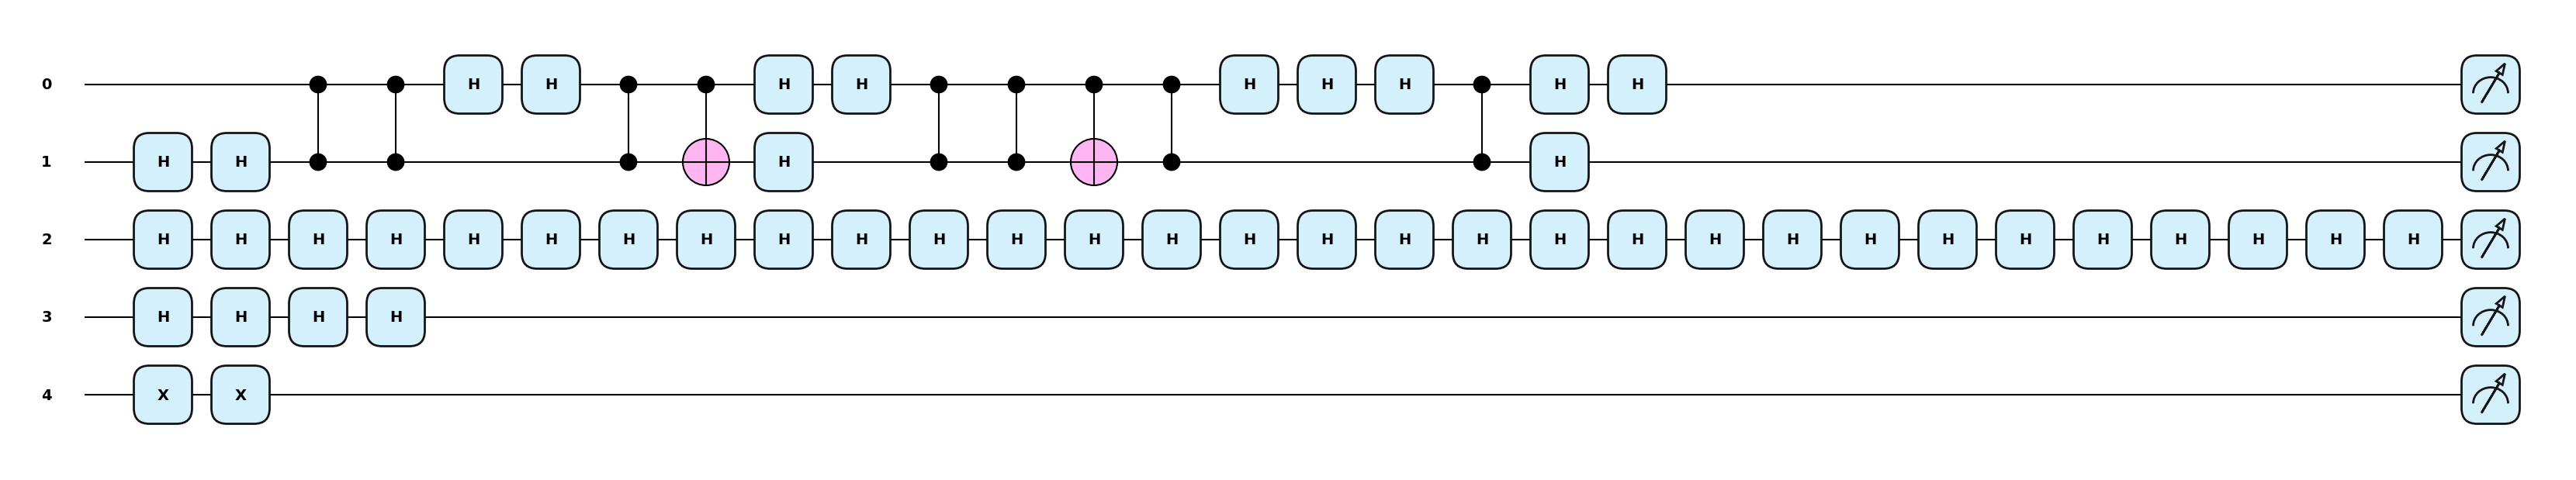

              0
num_qubit     5
num_gate     58
num_1q_gate  49
num_2q_gate   9
unitary       0
depth        30
None


In [4]:
seed = 100

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

print(summary_penny(circuit))

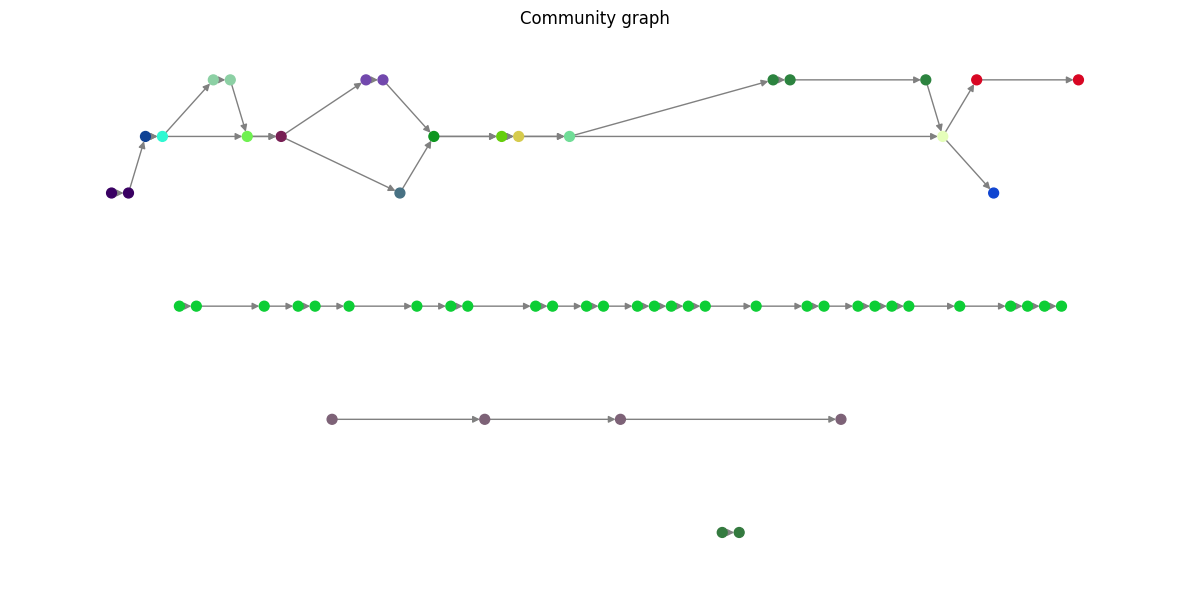

In [12]:
circuit_info = extract_info_from_qnode(circuit) # same with circuit_info

# to graph
pg = Penny_to_Graph(circuit)
G = pg.G

# community detection excluding barriers
G, communities = graph_alg_level_1(G, barriers=['QubitUnitary'] + q2)
community_graph(G, pg.pos, communities)

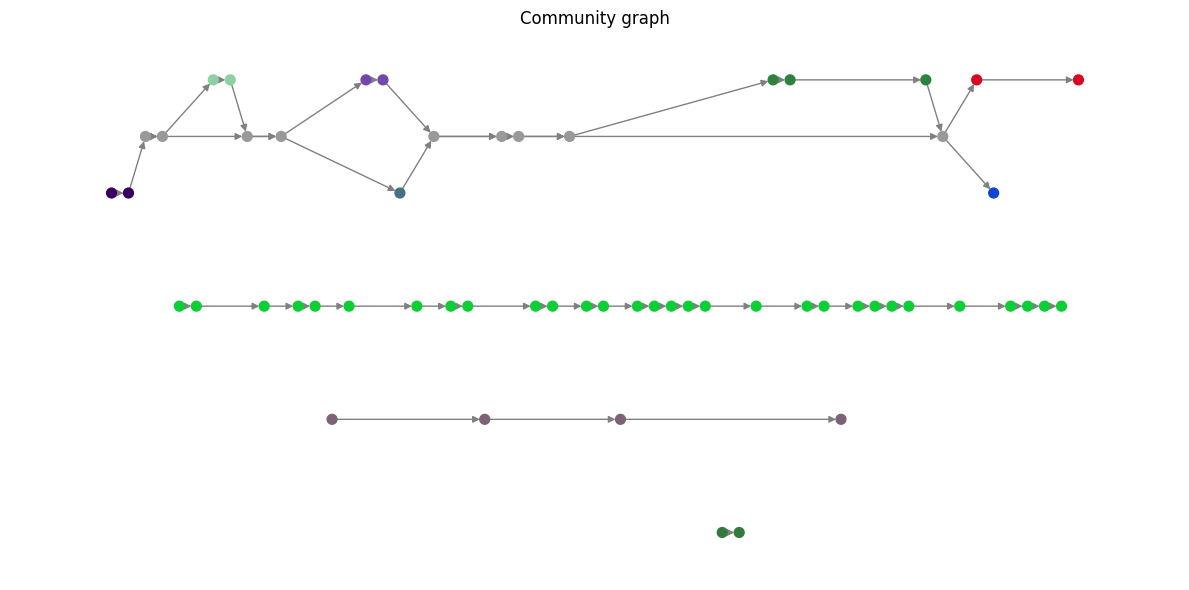

In [10]:
barriers = ['QubitUnitary'] + q2
barriers = [node for node in G.nodes if any(gate in node for gate in barriers)]
barrier_set = set(barriers)

G_sub = G.subgraph([node for node in G.nodes if node not in barrier_set])
base_communities = list(nx.connected_components(G_sub.to_undirected()))
community_graph(G, pg.pos, base_communities)

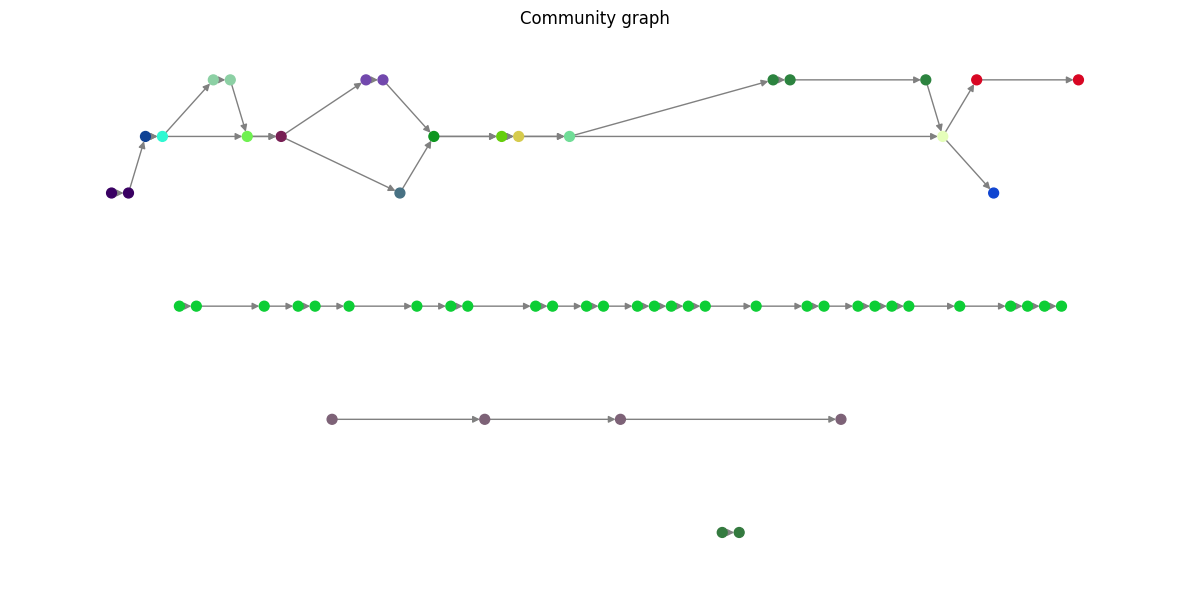

In [13]:
communities = []
for community in base_communities:
    wire_groups = defaultdict(set)
    for node in community:
        wire_set = tuple(sorted(G.nodes[node].get('wires', [])))
        wire_groups[wire_set].add(node)
    communities.extend(wire_groups.values())
G, communities = community_sort(G, communities, barriers)
community_graph(G, pg.pos, communities)

In [14]:
num_community = len(communities)

subcircuit_idx_arr = []
for i in range(num_community):
    temp_gate = [n for n in G.nodes if G.nodes[n].get('community') == i]
    temp_gate = [item for item in temp_gate if item]
    temp_com_label = [int(g.split('_')[1]) for g in temp_gate]
    subcircuit_idx_arr.append(temp_com_label)

In [20]:
# index to circuit_info
community_circuit_info = []
for idx_list in subcircuit_idx_arr:
    target = [circuit_info[j] for j in idx_list]
    if target == []:
        continue
    community_circuit_info.append(target)

In [21]:
for idx, ci in enumerate(community_circuit_info):
    if len(ci) > 1:
        matrix, wires = info_to_qnode_matrix(ci)
        # single-gate determination
        gate_name = determine_1q_gate(matrix)
        if gate_name == 'I':
            community_circuit_info[idx] = {} # clear the gate information
            print(idx, gate_name, wires)
        else:
            community_circuit_info[idx] =  [{'name': gate_name, 'wires': wires, 'params':[matrix]}] # replaced
            print(idx, gate_name, wires)

community_circuit_info = [item[0] for item in community_circuit_info if isinstance(item, list) and item and isinstance(item[0], dict)]

0 I [1]
3 I [2]
4 I [0]
7 I [3]
8 I [0]
14 I [4]
15 Hadamard [0]
17 I [0]


              0
num_qubit     2
num_gate     12
num_1q_gate   3
num_2q_gate   9
unitary       0
depth        12
None


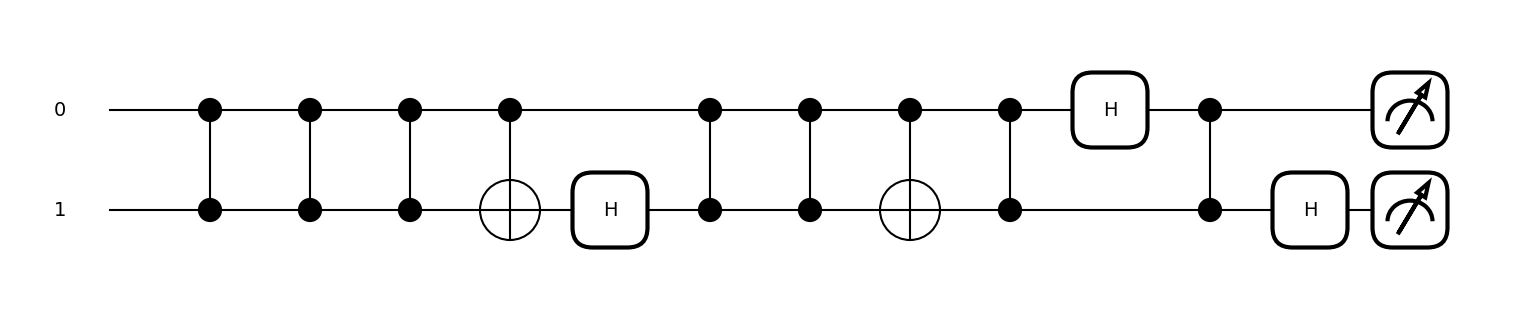

In [22]:
qnode_q1 = info_to_qnode(community_circuit_info)
print(summary_penny(qnode_q1))
qml.draw_mpl(qnode_q1)()
plt.show()

=== End of the level 1 optimization

In [101]:
circuit_info = extract_info_from_qnode(qnode_q1) # same with circuit_info
pg = Penny_to_Graph(qnode_q1)
G = pg.G
barriers = ['QubitUnitary'] + q1
# G, communities = graph_alg_level_2_test(G, barriers)

In [102]:
barriers = [node for node in G.nodes if any(gate in node for gate in barriers)]
barrier_set = set(barriers)
barrier_set

{'Hadamard_11', 'Hadamard_4', 'Hadamard_9'}

In [103]:
def is_barrier(barrier_set, shared_nodes):
    check = all(item in barrier_set for item in shared_nodes)
    return check

In [104]:
edge_to_remove = []
for e in G.edges():
    gate_2q = [n for n, attr in G.nodes(data=True) if attr.get('num_q') == 2]
    gate_1 = e[0]
    gate_2 = e[1]
    if gate_1 in gate_2q and gate_2 in gate_2q:
        neighbors1 = set(G.to_undirected().neighbors(gate_1))
        neighbors2 = set(G.to_undirected().neighbors(gate_2))
        shared_nodes = neighbors1.intersection(neighbors2)
        # print(e, neighbors1, neighbors2, shared_nodes)
        if shared_nodes and is_barrier(barrier_set, shared_nodes):
            edge_to_remove.append(e)
            print(e, neighbors1, neighbors2, shared_nodes)
G.remove_edges_from(edge_to_remove)

('CNOT_3', 'CZ_5') {'CZ_2', 'CZ_5', 'Hadamard_4'} {'CNOT_3', 'CZ_6', 'Hadamard_4'} {'Hadamard_4'}
('CZ_8', 'CZ_10') {'CNOT_7', 'CZ_10', 'Hadamard_9'} {'Hadamard_11', 'Hadamard_9', 'CZ_8'} {'Hadamard_9'}


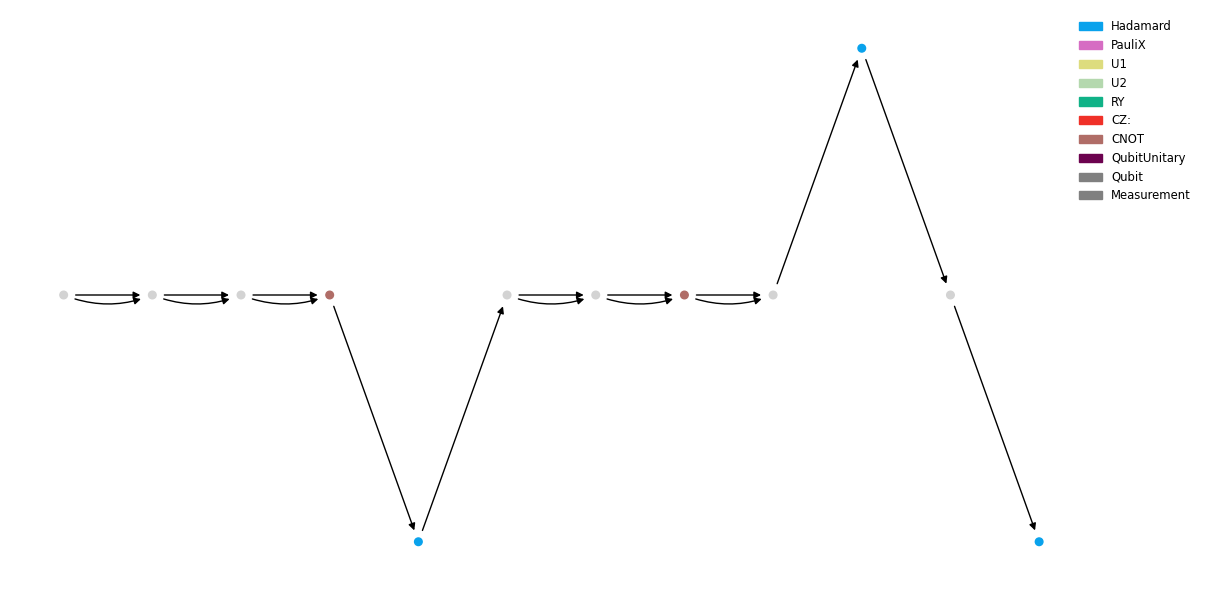

In [106]:
pg.show_graph(G)

In [108]:
G_sub = G.subgraph([node for node in G.nodes if node not in barrier_set])
# base_communities = list(nx.community.greedy_modularity_communities(G_sub))
base_communities = list(nx.connected_components(G_sub.to_undirected()))

for community in base_communities:
    wire_groups = defaultdict(set)
    for node in community:
        wire_set = tuple(sorted(G.nodes[node].get('wires', [])))
        wire_groups[wire_set].add(node)
    communities.extend(wire_groups.values())

G, communities = community_sort(G, communities, barriers)

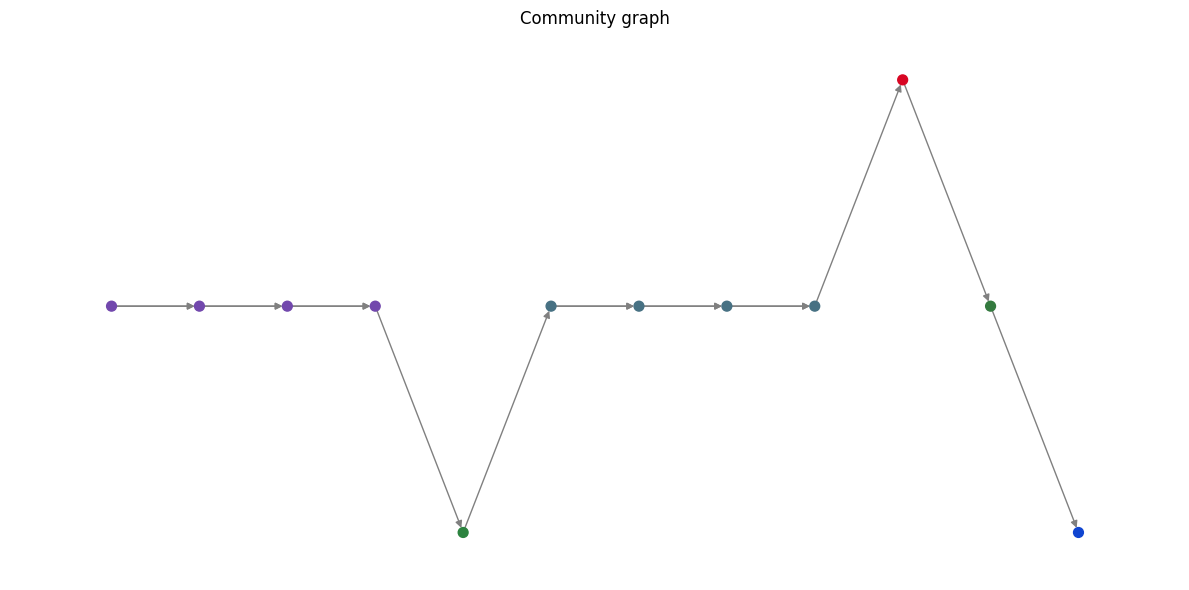

In [109]:
community_graph(G, pg.pos, communities)

In [110]:
# subcircuit_syntehsis_prep
num_community = len(communities)

subcircuit_idx_arr = []
for i in range(num_community):
    temp_gate = [n for n in G.nodes if G.nodes[n].get('community') == i]
    temp_gate = [item for item in temp_gate if item]
    temp_com_label = [int(g.split('_')[1]) for g in temp_gate]
    subcircuit_idx_arr.append(temp_com_label)

community_circuit_info = []
for idx_list in subcircuit_idx_arr:
    target = [circuit_info[j] for j in idx_list]
    if target == []:
        continue
    community_circuit_info.append(target)

community_circuit_info

[[{'name': 'CZ', 'wires': [0, 1], 'params': []},
  {'name': 'CZ', 'wires': [0, 1], 'params': []},
  {'name': 'CZ', 'wires': [1, 0], 'params': []},
  {'name': 'CNOT', 'wires': [0, 1], 'params': []}],
 [{'name': 'Hadamard', 'wires': [1], 'params': []}],
 [{'name': 'CZ', 'wires': [1, 0], 'params': []},
  {'name': 'CZ', 'wires': [1, 0], 'params': []},
  {'name': 'CNOT', 'wires': [0, 1], 'params': []},
  {'name': 'CZ', 'wires': [1, 0], 'params': []}],
 [{'name': 'Hadamard', 'wires': [0], 'params': []}],
 [{'name': 'CZ', 'wires': [1, 0], 'params': []}],
 [{'name': 'Hadamard', 'wires': [1], 'params': []}]]

[[ 1  0  0  0]
 [ 0  1  0  0]
 [ 0  0  0 -1]
 [ 0  0  1  0]] [0, 1]
[[ 1  0  0  0]
 [ 0  1  0  0]
 [ 0  0  0  1]
 [ 0  0 -1  0]] [0, 1]
             0
num_qubit    2
num_gate     6
num_1q_gate  3
num_2q_gate  3
unitary      0
depth        6
None


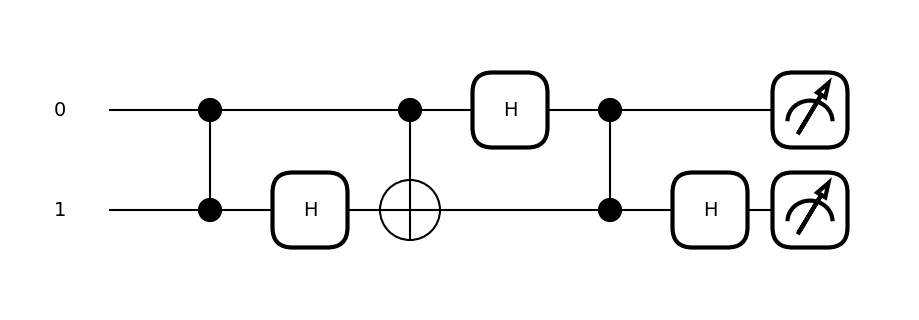

In [111]:
for idx, ci in enumerate(community_circuit_info):
    if len(ci) > 1:
        matrix, wires = info_to_qnode_matrix(ci)
        print(matrix, wires)
        # single-gate determination
        gate_name = determine_2q_gate(matrix)
        community_circuit_info[idx] = gate_info_array(gate_name, wires)

community_circuit_info = [item[0] for item in community_circuit_info if isinstance(item, list) and item and isinstance(item[0], dict)]

qnode_q2 = info_to_qnode(community_circuit_info)

# print results
print(summary_penny(qnode_q2))
qml.draw_mpl(qnode_q2)()
plt.show()